# Exploratory Data Analysis: Understanding What Drives Track Popularity

## 1. Introduction
This notebook continues directly from the data wrangling and preparation stage, using the final cleaned and enriched Spotify dataset created previously.

At this point, the data has been:
- Cleaned and validated
- Reshaped to correctly handle tracks with multiple artists
- Enriched with aggregated artist-level features
- Reduced to modeling-ready observations with minimal missing values

The purpose of this exploratory analysis is to examine distributions, relationships, and trends within the dataset in order to:
- Understand how audio features vary across tracks
- Explore how artist characteristics relate to track popularity
- Identify correlations and potential multicollinearity among features
- Surface patterns that may inform feature selection and modeling decisions

Insights from this notebook will directly guide preprocessing choices and model development in subsequent steps.

## 2. Libraries and Environment Setup
This section imports the core libraries used for data manipulation and visualization and configures display settings to support exploratory analysis.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Test
from scipy.stats import kruskal

# Display settings
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)
plt.rcParams["figure.figsize"] = (10, 6)

## 3. Read Files and Initial Verification
The enriched dataset produced in the data wrangling stage is loaded from a parquet file generated in the previous notebook.
A brief verification is performed to confirm the data loaded correctly and is ready for exploratory analysis.

In [2]:
df = pd.read_parquet("tracks_enriched_model.parquet")

In [3]:
df.head()

,track_id,track_name,track_popularity,duration_ms,explicit,artists,artist_id_list,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_year,artist_popularity_mean,artist_popularity_max,artist_followers_mean,artist_followers_max,n_artists,artist_genres_mean,artist_genres_max
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,[Uli],[45tIt06XoI0Iio4LBEVpls],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3,1922,4.0,4,91.0,91.0,1,0.0,0
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,[Fernando Pessoa],[14jtPCOoNZwquk5wd9DxrY],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1,1922,0.0,0,3.0,3.0,1,0.0,0
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,[Ignacio Corsini],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5,1922,23.0,23,3528.0,3528.0,1,2.0,2
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,[Ignacio Corsini],[5LiOoJbxVSAMkBS2fUm3X2],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3,1922,23.0,23,3528.0,3528.0,1,2.0,2
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,[Dick Haymes],[3BiJGZsyX9sJchTqcSA7Su],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4,1922,35.0,35,11327.0,11327.0,1,5.0,5


In [4]:
df.shape

(576126, 28)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576126 entries, 0 to 576125
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   track_id                576126 non-null  string 
 1   track_name              576126 non-null  string 
 2   track_popularity        576126 non-null  Int64  
 3   duration_ms             576126 non-null  Int64  
 4   explicit                576126 non-null  int64  
 5   artists                 576126 non-null  object 
 6   artist_id_list          576126 non-null  object 
 7   release_date            576126 non-null  string 
 8   danceability            576126 non-null  float64
 9   energy                  576126 non-null  float64
 10  key                     576126 non-null  Int64  
 11  loudness                576126 non-null  float64
 12  mode                    576126 non-null  Int64  
 13  speechiness             576126 non-null  float64
 14  acousticness        

The dataset loads as expected, with appropriate data types and no missing values present. No additional cleaning is required at this stage.

## 4. Target Variable: Track Popularity
Before exploring feature relationships, it is important to understand the behavior of the target variable.  
Track popularity serves as the outcome of interest for modeling and is examined first to assess its distribution, range, and potential skew.

In [6]:
df["track_popularity"].describe()

count     576126.0
mean     27.799377
std      18.307464
min            0.0
25%           13.0
50%           27.0
75%           41.0
max          100.0
Name: track_popularity, dtype: Float64

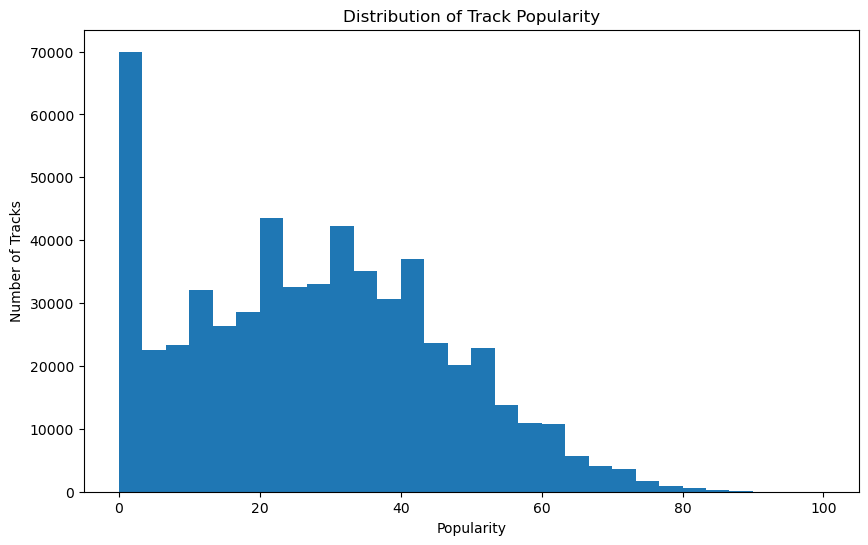

In [7]:
plt.hist(df["track_popularity"], bins=30)
plt.title("Distribution of Track Popularity")
plt.xlabel("Popularity")
plt.ylabel("Number of Tracks")
plt.show()

The popularity variable ranges from 0 to 100, with a mean of approximately 28 and a median of 27.  
This indicates that most tracks in the dataset have relatively low popularity, with a smaller proportion achieving high popularity scores.

The distribution shows moderate right skew, which is consistent with how attention is distributed across tracks on large music platforms. This distribution will be considered in downstream modeling and evaluation.

## 5. Audio Features: What Does a Typical Track Sound Like?
This section explores the audio characteristics of tracks in the dataset to establish baseline patterns in how songs are composed and produced. By examining both continuous audio measurements and discrete musical encodings, this analysis provides context for how tracks differ sonically before evaluating how these features relate to popularity.

### 5.1 Continuous Audio Features
These features represent continuous measurements of track characteristics and are examined to understand their distributions prior to analyzing their relationship with popularity.

In [8]:
continuous_audio_features = [
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo"
]

In [9]:
df[continuous_audio_features].describe().T

,count,mean,std,min,25%,50%,75%,max
danceability,576126.0,0.563308,0.165735,0.0,0.4530,0.577000,0.68500,0.991
energy,576126.0,0.541631,0.251683,0.0,0.3430,0.548000,0.74800,1.000
loudness,576126.0,-10.198368,5.079165,-60.0,-12.8860,-9.240000,-6.47600,5.376
speechiness,576126.0,0.105116,0.180699,0.0,0.0339,0.044200,0.07620,0.971
acousticness,576126.0,0.451229,0.348446,0.0,0.0990,0.425000,0.78500,0.996
instrumentalness,576126.0,0.110445,0.263353,0.0,0.0000,0.000023,0.00860,1.000
liveness,576126.0,0.214258,0.184568,0.0,0.0984,0.139000,0.27800,1.000
valence,576126.0,0.552944,0.257243,0.0,0.3470,0.564000,0.76975,1.000
tempo,576126.0,118.439860,29.761625,0.0,95.5320,117.246000,136.32200,246.381


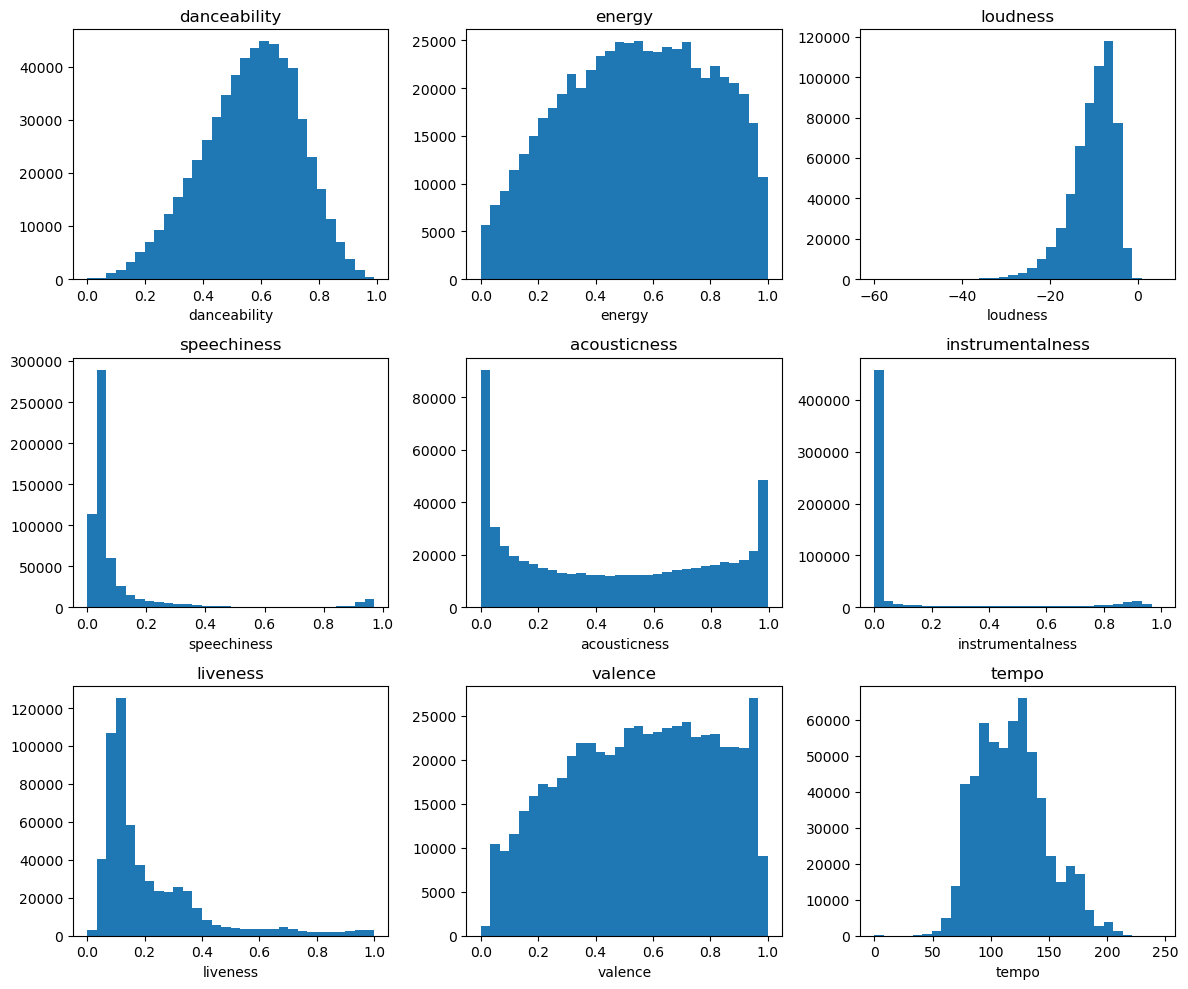

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))
axes = axes.flatten()

for ax, feature in zip(axes, continuous_audio_features):
    ax.hist(df[feature], bins=30)
    ax.set_title(feature)
    ax.set_xlabel(feature)
    ax.set_ylabel("")

plt.tight_layout()
plt.show()

**Continuous Audio Features Observations**
* Overall, the continuous audio features show meaningful variation across tracks.
* Danceability appears relatively symmetric compared to other features, while many audio attributes exhibit varying degrees of skew.
* Speechiness and instrumentalness show similar patterns, with most tracks clustered near zero and a smaller subset exhibiting higher values. This indicates that tracks without vocals and fully instrumental tracks are relatively uncommon.
* Acousticness exhibits a bimodal distribution, with peaks at both low and high values and fewer tracks in the mid-range, suggesting differences in production style.
* Loudness values are centered below zero, as loudness is measured in decibels relative to a reference level, where negative values indicate sound levels below that reference.
* Tempo shows wider variability across tracks, consistent with differences in musical style and arrangement.
* Most continuous audio features are bounded within fixed ranges, which will be considered when selecting scaling methods during preprocessing.

The following subsection examines categorical audio features, which capture discrete musical attributes and require different analytical treatment.

### 5.2 Categorical Audio Features
These features represent discrete musical attributes rather than continuous measurements. They are examined separately to understand how tracks are distributed across common musical structures.

In [11]:
categorical_audio_features = [
    "mode",
    "time_signature"
]

In [12]:
def plot_categorical_distribution(df, column):
    dist = df[column].value_counts(normalize=True).sort_index() * 100

    plt.figure(figsize=(6, 4))
    dist.plot(kind="bar")
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.xticks(rotation=0)
    plt.ylabel("Percentage of Tracks")
    plt.tight_layout()
    plt.show()

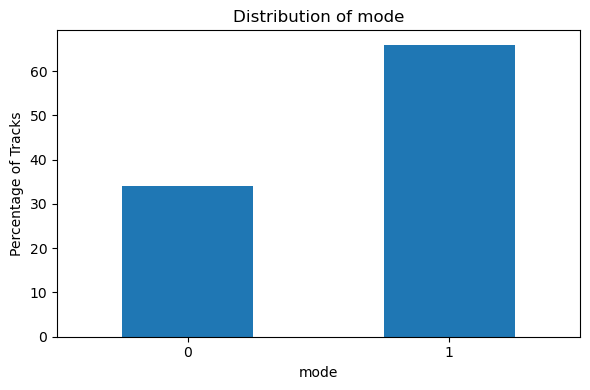

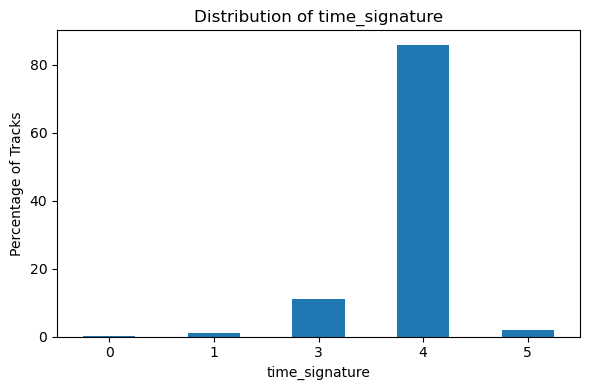

In [13]:
for col in categorical_audio_features:
    plot_categorical_distribution(df, col)

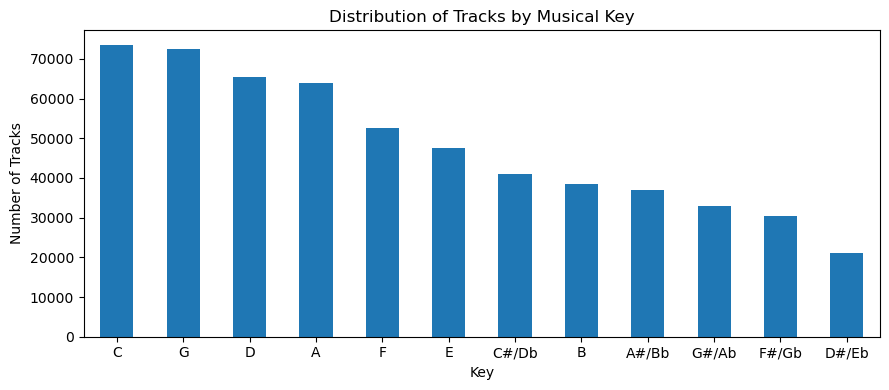

In [14]:
key_map = {
    0: "C",
    1: "C#/Db",
    2: "D",
    3: "D#/Eb",
    4: "E",
    5: "F",
    6: "F#/Gb",
    7: "G",
    8: "G#/Ab",
    9: "A",
    10: "A#/Bb",
    11: "B",
    -1: "Unknown"
}

df_key = df[["key"]].copy()
df_key["key_label"] = df_key["key"].map(key_map).fillna("Unknown")

key_counts = (
    df_key["key_label"]
    .value_counts() 
)

plt.figure(figsize=(9, 4))
key_counts.plot(kind="bar")
plt.xlabel("Key")
plt.xticks(rotation=0)
plt.ylabel("Number of Tracks")
plt.title("Distribution of Tracks by Musical Key")
plt.tight_layout()
plt.show()

In [15]:
(df["time_signature"] == 0).mean()
df = df[df["time_signature"] != 0]

**Categorical Audio Features Observations**
* The categorical audio features show strong concentration in a small number of common values, particularly for mode and time signature, indicating that most tracks follow standard musical conventions. In contrast, key is more evenly distributed across tonal centers, reflecting greater variation in pitch selection across tracks.
* A small number of tracks (<0.05%) contained a time signature value of 0, indicating an undetected meter. These observations were removed due to their negligible frequency.
* Overall, categorical audio features exhibit less variation than continuous audio features and will be incorporated into later analysis and modeling using appropriate encoding methods.

### 5.3 Summary: What Does a Typical Track Sound Like?

Taken together, the typical track in this dataset sounds familiar and broadly appealing. It is moderately danceable, carries a steady level of energy, and leans positive in tone without being overly intense or experimental. Most tracks focus on singing rather than talking, and fully instrumental tracks are relatively uncommon. Loudness and tempo generally fall within expected ranges, reinforcing a sense of balance rather than extremity.

From a musical structure standpoint, tracks largely follow standard conventions. Songs are most often written in major mode and a 4/4 time signature, while tonal key spans a wide range of values. Overall, tracks in the dataset tend to sound familiar, with variation driven primarily by production and expressive choices rather than departures from conventional musical structure.


## 6. Artist and Track Metadata
If audio features alone determined popularity, analysis could stop at sound and move directly into modeling. In practice, tracks do not exist on equal footing, and popularity is shaped by more than audio characteristics alone. This section examines artist and track metadata to provide additional context through attributes such as artist reach, release timing, and track level characteristics.

Artist and track metadata include both numerical attributes, such as duration and artist popularity, and categorical attributes, such as explicit content and identifiers. Identifier fields are retained for reference but are not analyzed directly.

### 6.1 Track Level Metadata
This subsection examines track level metadata that describe structural and release related attributes of individual tracks. These variables capture properties of the track itself, such as duration, release timing, explicit content, and the number of contributing artists, and are analyzed to understand how tracks are distributed along these dimensions.

In [16]:
track_level_continuous_vars = [
    "duration_ms",
    "release_year",
    "n_artists"
]

df[track_level_continuous_vars].describe().T

,count,mean,std,min,25%,50%,75%,max
duration_ms,575848.0,229885.550894,122005.205444,15307.0,175360.0,215000.0,263899.25,5621218.0
release_year,575848.0,1988.299907,22.782283,1900.0,1974.0,1992.0,2007.0,2021.0
n_artists,575848.0,1.293805,0.874538,1.0,1.0,1.0,1.0,58.0


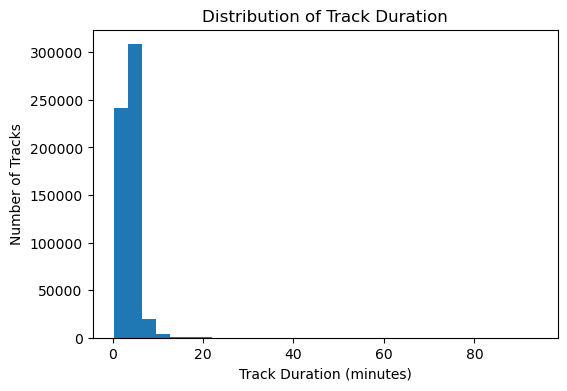

In [17]:
plt.figure(figsize=(6,4))
plt.hist(df["duration_ms"] / 60000, bins=30)
plt.xlabel("Track Duration (minutes)")
plt.ylabel("Number of Tracks")
plt.title("Distribution of Track Duration")
plt.show()

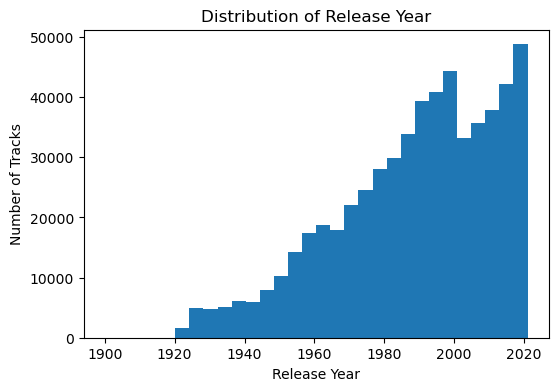

In [18]:
plt.figure(figsize=(6,4))
plt.hist(df["release_year"], bins=30)
plt.xlabel("Release Year")
plt.ylabel("Number of Tracks")
plt.title("Distribution of Release Year")
plt.show()

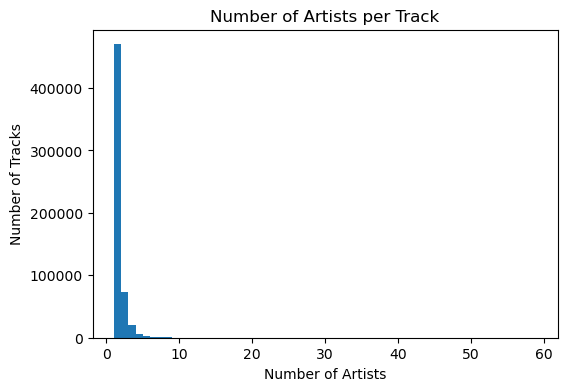

In [19]:
plt.figure(figsize=(6,4))
plt.hist(df["n_artists"], bins=range(1, df["n_artists"].max() + 2))
plt.xlabel("Number of Artists")
plt.ylabel("Number of Tracks")
plt.title("Number of Artists per Track")
plt.show()

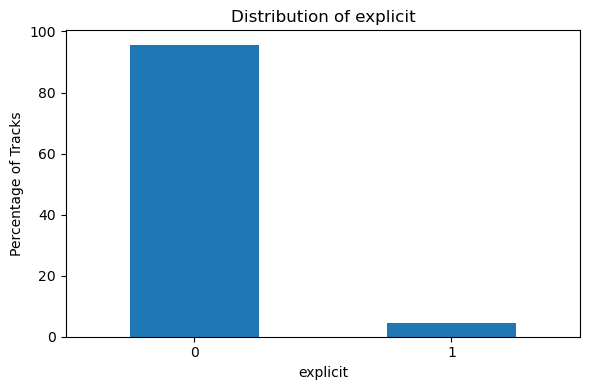

In [20]:
plot_categorical_distribution(df, "explicit")

Track level metadata show that most tracks follow standard structural conventions. Track duration is concentrated around typical song lengths, with a small number of substantially longer tracks contributing to a right skew in the distribution. Release years span roughly from the early twentieth century through the early 2020s, with the majority of tracks concentrated between the 1920s and 2020.

Most tracks are attributed to a single artist, with collaborations occurring less frequently. A small number of tracks involve many contributing artists, which increases variability but does not represent the typical case. Together, these variables describe the basic structure and release characteristics of tracks prior to examining artist context metadata.

### 6.2 Artist Context Metadata
This subsection focuses on artist context metadata, which summarize attributes of the artists associated with each track. These variables are aggregated to the track level and reflect characteristics such as artist popularity, audience reach, and genre breadth, providing contextual information that extends beyond the audio and structural properties of the track itself.

In [21]:
artist_context_vars = [
    "artist_popularity_mean",
    "artist_popularity_max",
    "artist_followers_mean",
    "artist_followers_max",
    "artist_genres_mean",
    "artist_genres_max"
]

df[artist_context_vars].describe().T

,count,mean,std,min,25%,50%,75%,max
artist_popularity_mean,575848.0,49.899081,19.576851,0.0,37.0,51.0,64.0,100.0
artist_popularity_max,575848.0,51.423577,19.865144,0.0,39.0,53.0,66.0,100.0
artist_followers_mean,575848.0,1053271.932286,3739311.674069,0.0,12268.0,95038.0,613060.0,78900234.0
artist_followers_max,575848.0,1199922.549115,4192885.450996,0.0,13727.0,105622.0,647585.0,78900234.0
artist_genres_mean,575848.0,3.161693,2.48669,0.0,1.0,3.0,4.0,21.0
artist_genres_max,575848.0,3.366531,2.545933,0.0,1.0,3.0,5.0,21.0


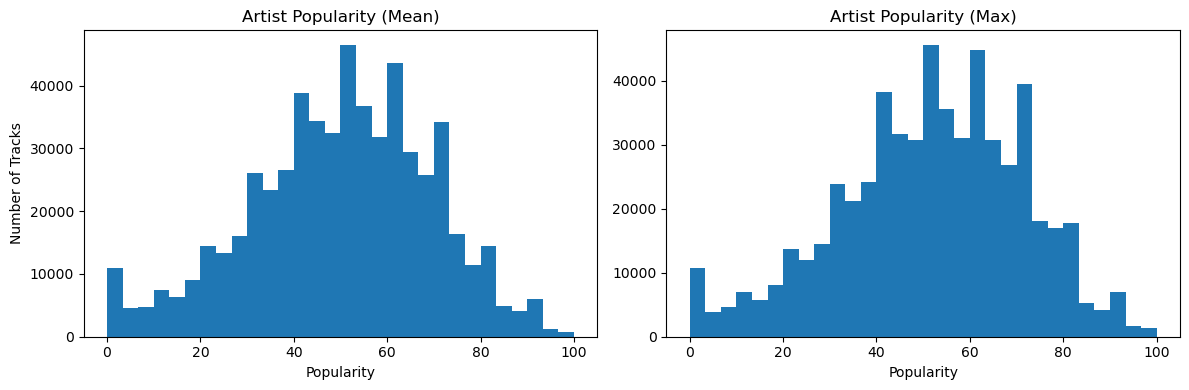

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df["artist_popularity_mean"], bins=30)
axes[0].set_title("Artist Popularity (Mean)")
axes[0].set_xlabel("Popularity")
axes[0].set_ylabel("Number of Tracks")

axes[1].hist(df["artist_popularity_max"], bins=30)
axes[1].set_title("Artist Popularity (Max)")
axes[1].set_xlabel("Popularity")

plt.tight_layout()
plt.show()

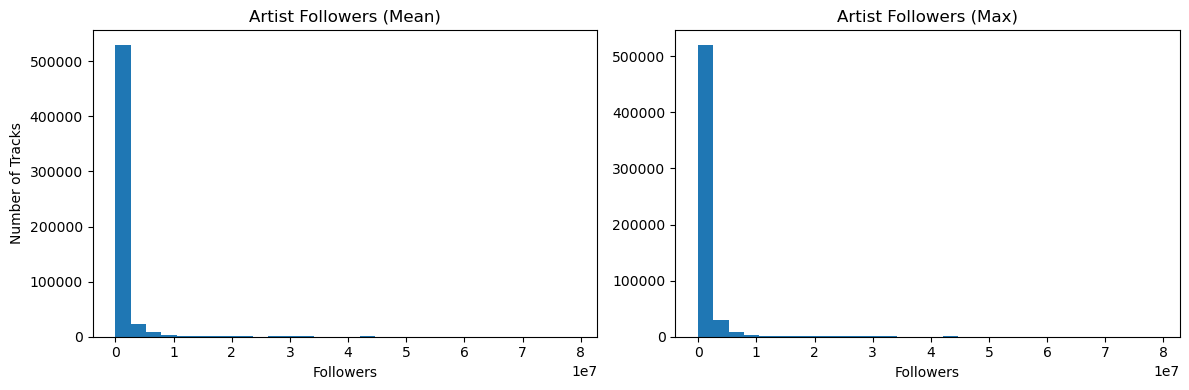

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df["artist_followers_mean"], bins=30)
axes[0].set_title("Artist Followers (Mean)")
axes[0].set_xlabel("Followers")
axes[0].set_ylabel("Number of Tracks")

axes[1].hist(df["artist_followers_max"], bins=30)
axes[1].set_title("Artist Followers (Max)")
axes[1].set_xlabel("Followers")

plt.tight_layout()
plt.show()

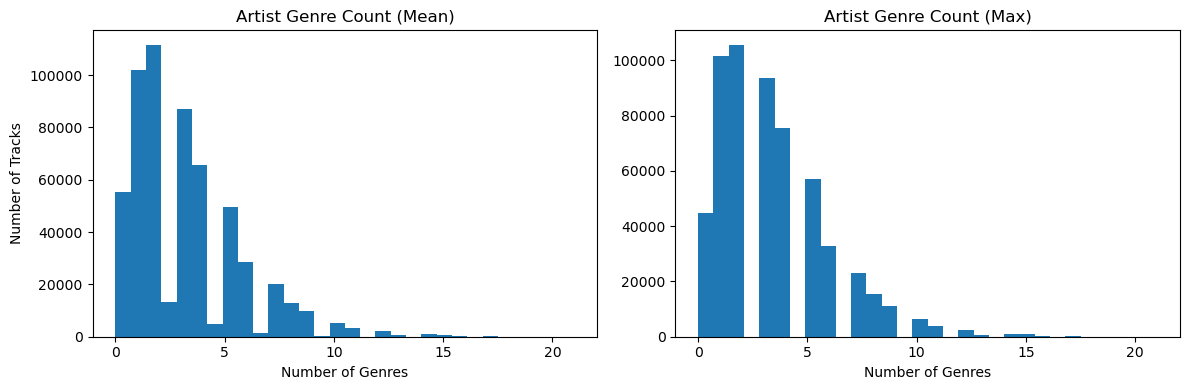

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df["artist_genres_mean"], bins=30)
axes[0].set_title("Artist Genre Count (Mean)")
axes[0].set_xlabel("Number of Genres")
axes[0].set_ylabel("Number of Tracks")

axes[1].hist(df["artist_genres_max"], bins=30)
axes[1].set_title("Artist Genre Count (Max)")
axes[1].set_xlabel("Number of Genres")

plt.tight_layout()
plt.show()

Artist context metadata show substantial variability across tracks. Artist popularity scores are generally centered around moderate values, indicating that most tracks involve artists with established but not extreme levels of recognition. Differences between mean and maximum popularity values reflect collaborations where one contributing artist may be more prominent than others.

Follower counts exhibit strong right skew, with most tracks associated with artists who have relatively modest audiences and a smaller number linked to artists with very large followings. Genre related attributes indicate that most artists are associated with a limited number of genres, while a smaller subset spans broader genre categories. Differences between mean and maximum genre counts further highlight the presence of collaborations involving artists with varying catalog breadth. Together, these variables provide contextual information about the artists behind each track prior to examining relationships with popularity.

### 6.3 Identifier Fields
Identifier fields are included in the dataset to support reference, linking, and traceability across data sources. These fields are retained for completeness but are not analyzed directly, as they do not convey meaningful variation for exploratory analysis.

### 6.4 Summary of Artist and Track Metadata

Together, track level and artist context metadata provide important non audio context for each track, capturing structural attributes and artist related characteristics that are not reflected in audio features alone. These variables establish additional dimensions along which tracks differ and set the foundation for subsequent analysis of how both sound and context relate to popularity.

## 7. What Seems to Drive Track Popularity?
With an understanding of how tracks sound and the context around their release, this section takes a closer look at how popularity varies across different features. Rather than assuming popularity is driven by one obvious factor, the analysis explores whether it aligns more with artist context such as follower counts, with audio characteristics like energy or instrumentalness, or with patterns that are less obvious. These relationships are explored descriptively to help guide later modeling decisions.


### 7.1 Numerical Features and Popularity
This subsection examines relationships among numerical features and between numerical features and track popularity using correlation analysis. Correlations among features are first assessed to identify shared structure and potential redundancy, followed by an examination of how individual numeric attributes relate to popularity. These patterns are explored to inform subsequent modeling decisions.

#### 7.1.1 Relationships Among Numerical Features
Before examining relationships with popularity, correlations among numerical features are assessed to identify redundancy and shared structure.

In [25]:
numeric_variables = [
    # audio features
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",

    # track metadata
    "duration_ms",
    "release_year",
    "n_artists",

    # artist context metadata
    "artist_popularity_mean",
    "artist_popularity_max",
    "artist_followers_mean",
    "artist_followers_max",
    "artist_genres_mean",
    "artist_genres_max"
]

In [26]:
numeric_feature_corr = df[numeric_variables].corr()

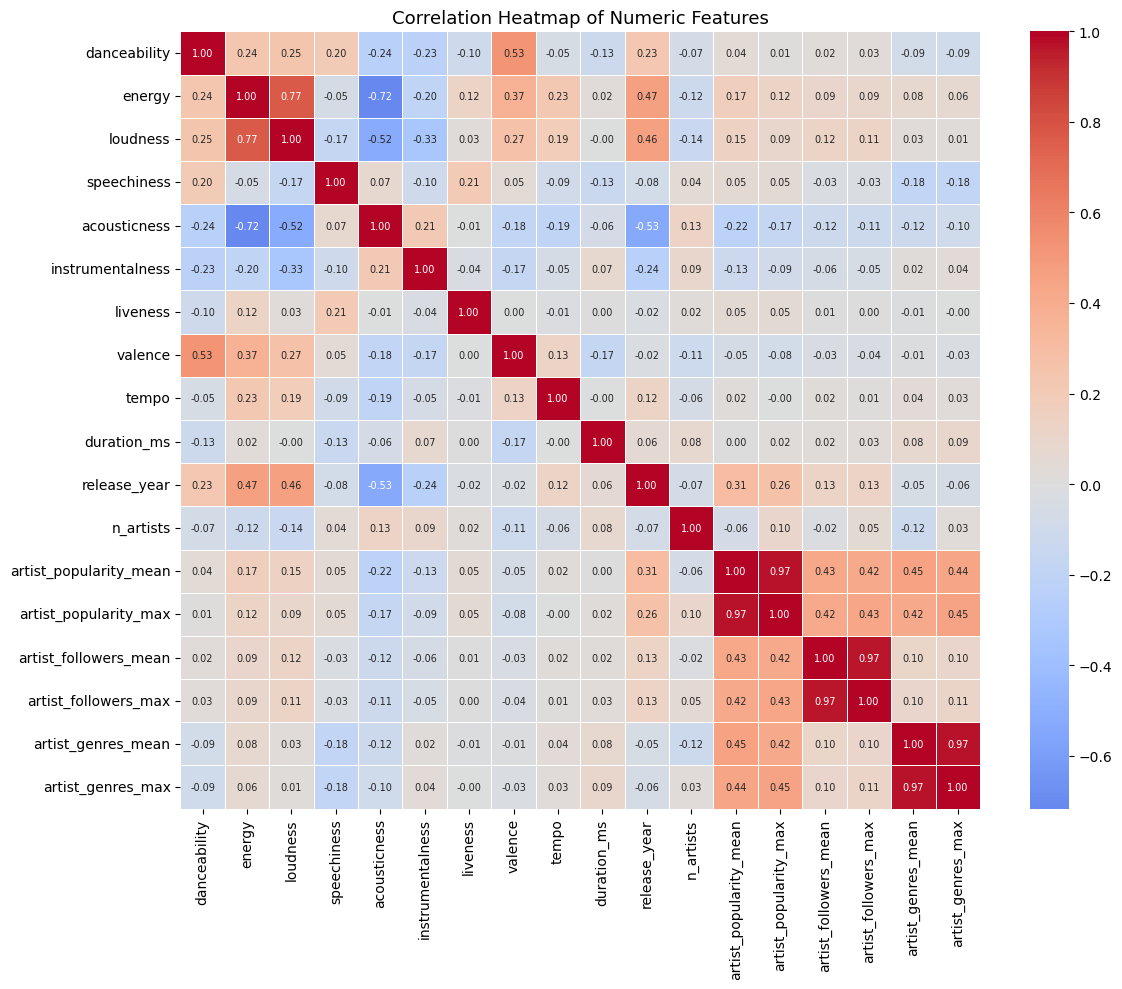

In [27]:
plt.figure(figsize=(12, 10))

sns.heatmap(
    numeric_feature_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    annot_kws={"size": 7},
    linewidths=0.4
)

plt.title("Correlation Heatmap of Numeric Features", fontsize=13)
plt.tight_layout()
plt.show()

**Correlation Heatmap Observations**

- Audio feature relationships show several expected associations. Energy and loudness are strongly positively correlated, while both are strongly negatively correlated with acousticness, reflecting common production tradeoffs between loud, high energy tracks and more acoustic styles. Danceability and valence exhibit a moderate positive correlation, suggesting that more danceable tracks tend to have a more positive tone.

- Artist context variables display very strong correlations between mean and maximum variants of popularity, follower counts, and genre counts. This indicates substantial redundancy among these measures. To reduce multicollinearity in later modeling, one representative metric from each highly correlated pair will be selected rather than including both.

- Audio features and artist context are generally weakly correlated, indicating that how a track sounds is largely independent of artist reach or catalog breadth and that these features capture complementary dimensions of information.

- Release year shows moderate correlations with several audio and artist context features. Newer tracks tend to be louder and more energetic and less acoustic, and artist popularity metrics also vary with release timing, highlighting temporal shifts in both production style and artist reach.

#### 7.1.2 Numerical Features Associated with Popularity
This subsection examines how numerical features relate to track popularity. Correlation analysis is used to assess the strength and direction of linear associations, followed by visual inspection to explore patterns that may not be fully captured by correlation alone.

In [28]:
df_sample = df.sample(n=8000, random_state=42)

In [29]:
corr_with_popularity = (
    df[numeric_variables + ["track_popularity"]]
    .corr()["track_popularity"]
    .drop("track_popularity")
    .sort_values(ascending=False)
)

corr_with_popularity

release_year              0.610466
artist_popularity_mean    0.569908
artist_popularity_max     0.525418
loudness                  0.336395
energy                    0.311881
artist_followers_max      0.241438
artist_followers_mean     0.239456
danceability              0.192137
artist_genres_mean        0.173628
artist_genres_max         0.162066
tempo                     0.074037
duration_ms               0.034722
valence                   0.003093
speechiness              -0.049046
liveness                 -0.050423
n_artists                -0.072944
instrumentalness         -0.237142
acousticness             -0.382437
Name: track_popularity, dtype: float64

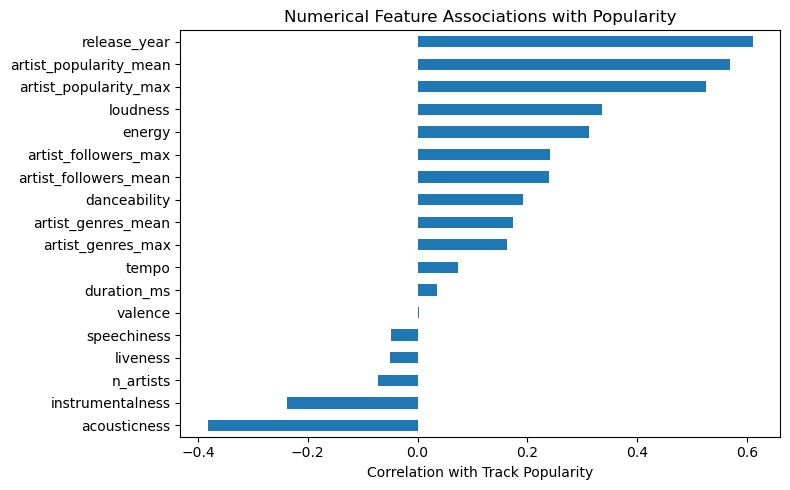

In [30]:
plt.figure(figsize=(8,5))
corr_with_popularity.plot(kind="barh")
plt.xlabel("Correlation with Track Popularity")
plt.title("Numerical Feature Associations with Popularity")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [31]:
popularity_plot_vars = [
    "release_year",
    "artist_popularity_mean",
    "energy",
    "loudness",
    "danceability",
    "acousticness",
    "instrumentalness",
    "artist_followers_max"
]

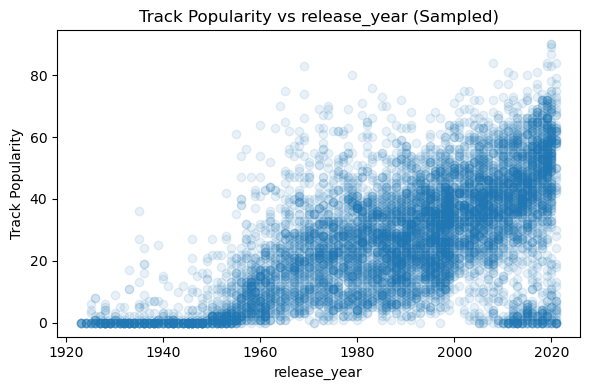

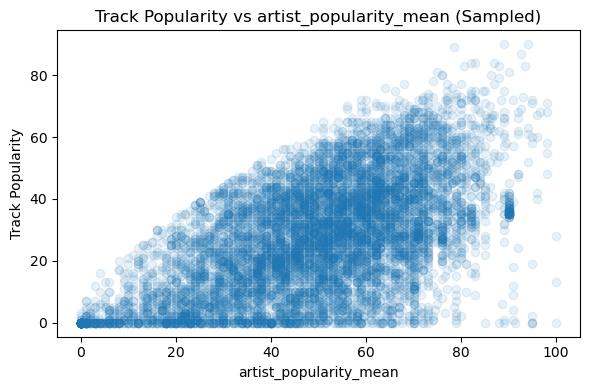

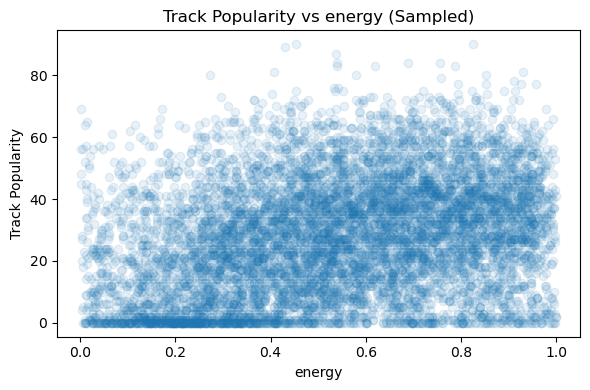

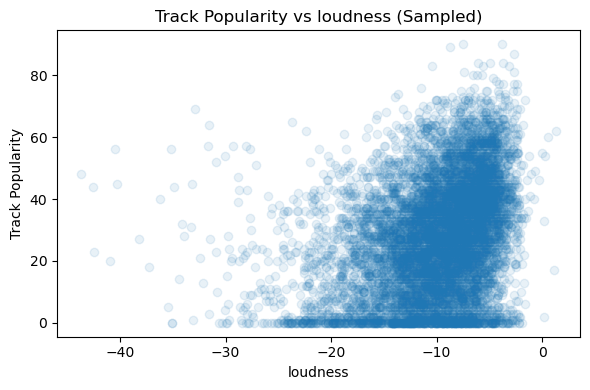

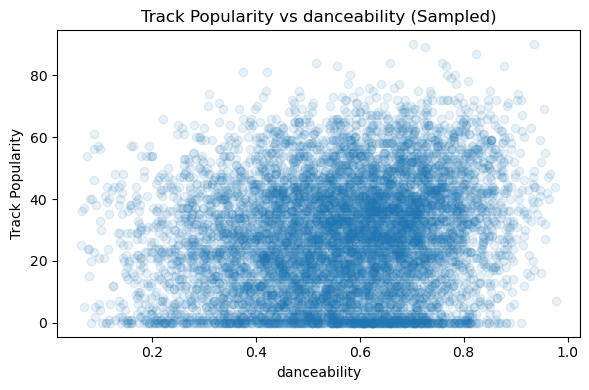

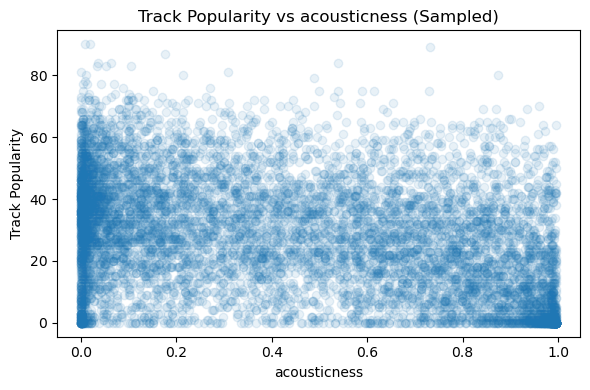

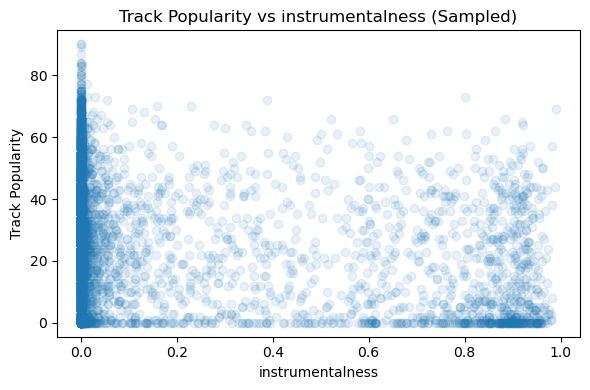

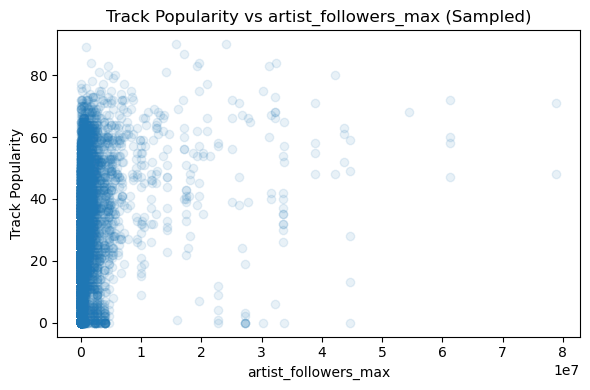

In [32]:
for var in popularity_plot_vars:
    plt.figure(figsize=(6, 4))
    plt.scatter(
        df_sample[var],
        df_sample["track_popularity"],
        alpha=0.1
    )
    plt.xlabel(var)
    plt.ylabel("Track Popularity")
    plt.title(f"Track Popularity vs {var} (Sampled)")
    plt.tight_layout()
    plt.show()

Scatterplots suggest that the relationship between acousticness and popularity is not gradual. Most tracks have low acousticness values and span a wide range of popularity, while fully acoustic tracks are relatively rare and tend to have very low popularity. This pattern indicates a threshold-like effect rather than a smooth linear relationship.

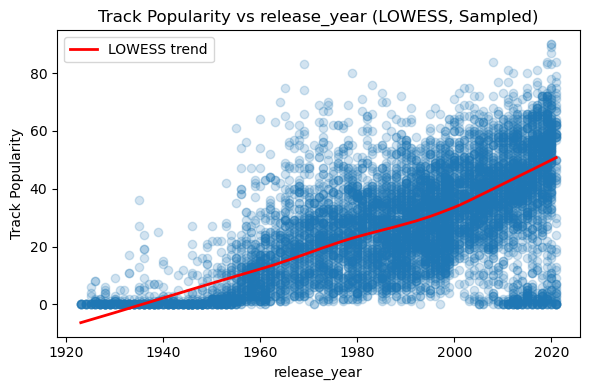

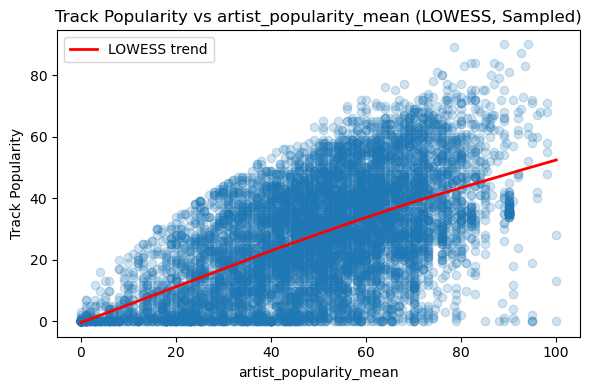

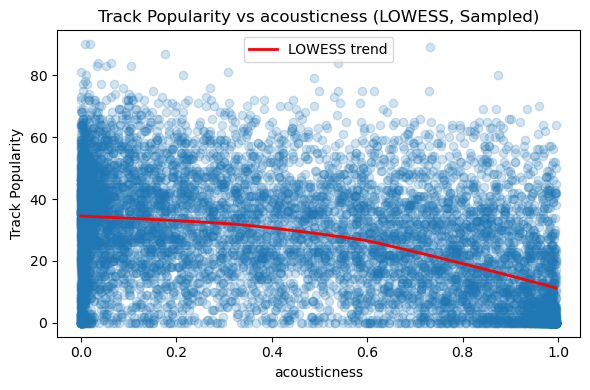

In [33]:
lowess_vars = [
    "release_year",
    "artist_popularity_mean",
    "acousticness",
]

for var in lowess_vars:
    plt.figure(figsize=(6, 4))
    sns.regplot(
        x=var,
        y="track_popularity",
        data=df_sample,
        lowess=True,
        scatter_kws={"alpha": 0.2},
        line_kws={
            "color": "red",
            "linewidth": 2,
            "label": "LOWESS trend"
        }
    )
    plt.xlabel(var)
    plt.ylabel("Track Popularity")
    plt.title(f"Track Popularity vs {var} (LOWESS, Sampled)")
    plt.legend()
    plt.tight_layout()
    plt.show()

**Numerical Features and Popularity Association Observations**
* Release year shows the strongest positive association with popularity, reflecting strong recency effects in how popularity is measured.
* Artist popularity is also positively associated with track popularity, though outcomes vary widely at all popularity levels. 
* Loudness has a moderate positive relationship with popularity, while still exhibiting wide variability across tracks.
* Acousticness shows a constraining, non-linear pattern, with highly acoustic tracks less likely to reach high popularity.
* Instrumentalness is heavily concentrated at zero and, while negatively associated with popularity, is not emphasized further due to limited variation.
* Other audio features show weak relationships with popularity in isolation and are retained for evaluation during modeling.

### 7.2 Categorical Features and Popularity
This subsection explores how track popularity varies across categorical features by comparing popularity distributions between groups. Rather than relying on correlation, group based visualizations are used to assess whether certain categories are associated with differences in typical popularity.

In [34]:
categorical_variables = [
    # audio features except key (studied separately)
    "mode",
    "time_signature",

    # track metadata
    "explicit"
]

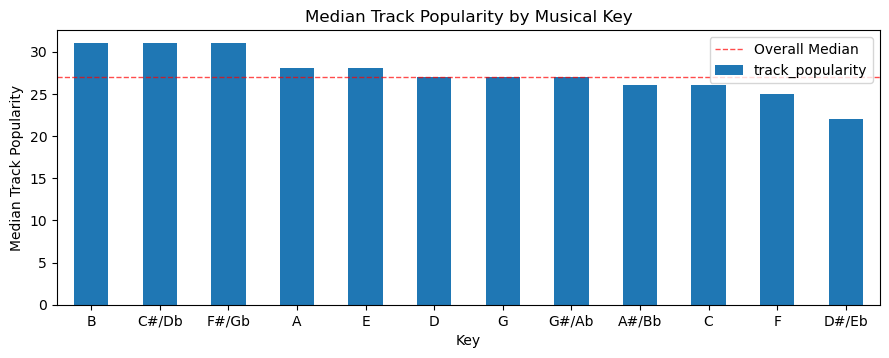

In [35]:
df_key = df[["key", "track_popularity"]].dropna(subset=["key", "track_popularity"]).copy()
df_key["key_label"] = df_key["key"].map(key_map)

median_popularity_by_key = (
    df_key.groupby("key_label")["track_popularity"]
    .median()
    .sort_values(ascending=False)
)

overall_median = df["track_popularity"].median()

plt.figure(figsize=(9, 4))
ax = median_popularity_by_key.plot(kind="bar")

ax.axhline(
    overall_median,
    color="red",
    linestyle="--",
    linewidth=1,
    alpha=0.7,
    label="Overall Median"
)

ax.set_xlabel("Key")
ax.set_ylabel("Median Track Popularity")
ax.set_title("Median Track Popularity by Musical Key")
ax.legend()

plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

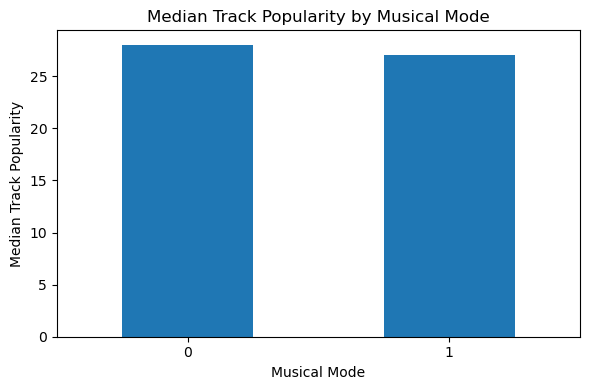

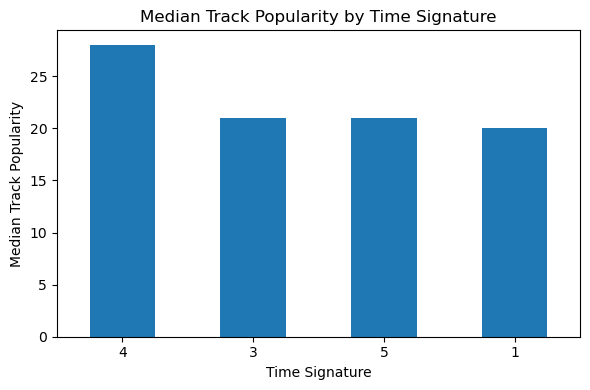

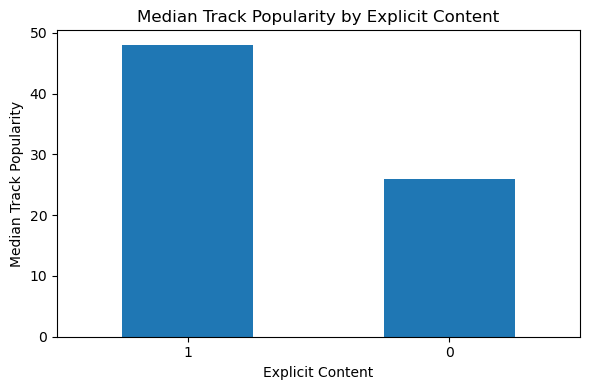

In [36]:
label_names = {
    "explicit": "Explicit Content",
    "mode": "Musical Mode",
    "time_signature": "Time Signature"
}

for var in categorical_variables:
    df_plot = (
        df[[var, "track_popularity"]]
        .dropna(subset=[var, "track_popularity"])
        .copy()
    )

    df_plot[var] = df_plot[var].astype(str)

    median_popularity = (
        df_plot.groupby(var)["track_popularity"]
        .median()
        .sort_values(ascending=False)
    )

    plt.figure(figsize=(6, 4))
    ax = median_popularity.plot(kind="bar")

    ax.set_xlabel(label_names.get(var, var))
    ax.set_ylabel("Median Track Popularity")
    ax.set_title(f"Median Track Popularity by {label_names.get(var, var)}")

    ax.tick_params(axis="x", rotation=0)

    plt.tight_layout()
    plt.show()

The visualizations in this section suggested that popularity distributions differ across several categorical features. To determine whether these observed differences reflect meaningful structure rather than random variation, a non-parametric statistical test was applied to compare popularity distributions across categories.

In [37]:
def kruskal_test(df, cat_var, target="track_popularity"):
    groups = [
        group[target].values
        for _, group in df.groupby(cat_var)
    ]
    stat, p = kruskal(*groups)
    return stat, p

for var in ["explicit", "mode", "time_signature", "key"]:
    stat, p = kruskal_test(df, var)
    print(f"{var}: H={stat:.2f}, p-value={p:.4e}")

explicit: H=22724.41, p-value=0.0000e+00
mode: H=675.61, p-value=6.0291e-149
time_signature: H=10474.92, p-value=0.0000e+00
key: H=3795.28, p-value=0.0000e+00


**Categorical Features and Popularity Summary**
* Explicit content shows a clear and meaningful separation, with explicit tracks consistently exhibiting higher typical popularity than non-explicit tracks. This distinction is both visually apparent and statistically significant.
* Time signature differences are driven primarily by 4/4, which outperforms other meters that otherwise show similar popularity distributions.
* Musical mode exhibits only minor differences, with major and minor tracks showing largely overlapping popularity distributions despite statistical significance.
* Musical key varies in typical popularity, with a small set of keys performing better on average, though these effects must be interpreted alongside key frequency.
* Statistical testing confirms that all examined categorical features are associated with non-random differences in popularity, supporting their inclusion in models that can capture non-linear and interaction effects.
* Taken together, categorical features appear to shape popularity in combination with other factors, rather than acting as standalone drivers.

### 7.3 Summary: What Seems to Drive Track Popularity?

* Release year is the strongest and most consistent signal, with newer tracks generally showing much higher popularity.
* Artist popularity still matters, but its effect is secondary to recency.
* Explicit tracks tend to be more popular on average, suggesting that content style and audience targeting play a role.
* Audio features add nuance but rarely separate popular and unpopular tracks on their own, indicating that sound alone does not explain popularity.

## 8. Key Insights and Modeling Implications

**Key Insights**
* Popularity is strongly shaped by context and exposure, with release year and artist-level attributes showing the strongest associations. Newer tracks and tracks by more established artists consistently perform better.
* Audio features influence popularity, but rarely in isolation. Features such as loudness and acousticness shape constraints or tendencies rather than determining outcomes outright.
* Categorical features show meaningful but uneven effects. Explicit content stands out as a strong differentiator, while musical mode and time signature show smaller, more subtle separations.
* Performance and prevalence are not the same. Certain musical keys exhibit higher typical popularity despite being less common, highlighting the importance of separating frequency from performance.
* Across features, no single variable fully explains popularity, reinforcing the need to consider interactions and combined effects.


**Modeling Implications**
* The observed relationships support the use of models that can capture non-linear patterns and interactions, as many effects are not strictly linear or independent.
* Categorical variables should be retained in modeling, as statistical tests confirm non-random differences in popularity distributions, even when visual separations are modest.
* Given the strength of artist-level features and recency effects, baseline models should incorporate contextual and metadata features alongside audio characteristics.
* Tree-based models or other flexible approaches are well-suited to this problem, as they can naturally handle mixed feature types and interaction effects without extensive manual feature engineering.
* Genre information, while not deeply explored in EDA due to its high dimensionality, is likely to add value in modeling and should be evaluated using appropriate encoding strategies.